# Logistic regression via gradient descent
### Your name here

In [1]:
import numpy as np
import numpy.linalg as LA
from sklearn.datasets import load_boston, load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

## Define functions used for performing gradient descent

#### logistic function

In [2]:
def logistic(x):
    return 1/(1 + np.exp(-x))

#### function logistic_gradient(theta,X,y) -- compute analytic gradients for logistic regression

In [3]:
# compute gradients at theta for logistic cost function
# (refer to Equation 4-18 of the Geron textbook)
# theta is an array of coefficients, X is an augmented 
# feature matrix, y is an array of numeric labels
def logistic_gradient(theta, X, y):
    partials = []
    
    for j in range(len(theta)):
        m = []
        for i in range(len(X)):
            m.append((logistic(theta.T.dot(X[i,:])) - y[i]) * X[i,j])
        partials.append(np.mean(m))
        
    return(np.array(partials))

In [4]:
# test logistic_gradient
m = 3
theta = np.array([0.5,1.0])
X = np.array([[0.27], [0.66], [0.87]])
X0 = np.ones((m,1))
X_aug = np.hstack((X0, X))
y = np.array([0,0,1])

# result should be about [0.41, 0.17]
print(logistic_gradient(theta, X_aug, y))

[0.41407792 0.17025032]


#### function grad_descent(grads, alpha, max_iterations, min_change) - gradient descent algorithm

In [5]:
# use gradient descent to find a vector that is the approximate
# minimum of a function whose gradients can be computed with
# function grads
# grads - computes gradients of a function
# n - length of vector expected by grads as input
# alpha - learning rate
# max_iterations and min_change are stopping conditions:
#   max_iterations - return if max_iterations performed
#   min_change - return if change to x is less than min_change
def grad_descent(grads, n, alpha=0.01, max_iterations=10000, min_change=0.0001):
    x = np.zeros(n)        # this is just one way to initialize
    num_iterations = 0
    while num_iterations <= max_iterations:
        x_last = x
        x = x - grads(x)*alpha    # update x
        resid = x - x_last
        change = np.sqrt(resid.dot(resid))
        if change < min_change:
            print("stopped on min change")
            return(x)
        num_iterations += 1
    print("stopped on max iterations")
    return(x)

### Load and preprocess the 1978 Boston housing data

In [6]:
dat = load_boston()
  
X = dat['data'][:,5:6]   # avg. number of rooms
y = dat['target']        # house price (thousands of dollars)
dat['feature_names']

# remove data where the house price is exactly the max value
# of 50.0; this is a result of censoring.
not_max_rows = (y != 50.0)
y = y[not_max_rows]
X = X[not_max_rows]
n,m = X.shape

# convert target to 0/1, with 1 for house price > 25
y = np.where(y > 25.0, 1.0, 0.0)

The augmented matrix of training data, with 1's in the first column.

In [7]:
X0 = np.ones((n,1))
X_aug = np.hstack((X0, X))

We're going to try to predict if a house is expensive by looking at the number of rooms.

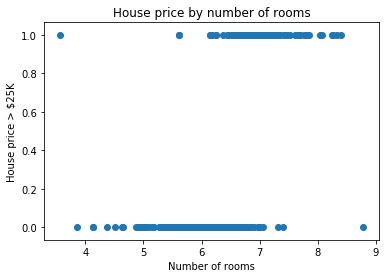

In [8]:
plt.scatter(X, y)
plt.xlabel('Number of rooms')
plt.ylabel('House price > $25K')
plt.title('House price by number of rooms');

### function log_loss(theta, X, y) -- logistic regression cost function

In [9]:
# logistic regression loss function
# (refer to Equation 4-17 of the Geron textbook)
# X is an augmented feature matrix of two columns, y is an array of numeric labels
def log_loss(theta, X, y):
    loss = []
    
    for i in range(len(y)):
        p = logistic(theta.dot(X[i,:]))
        loss.append(y[i] * np.log(p) + (1 - y[i]) * np.log(1 - p))
    
    return(-np.mean(loss))

In [10]:
# a version of the loss function where the training data is hidden
def f_loss(theta):
    return log_loss(theta, X_aug, y)

Plot log loss for a range of coefficient values

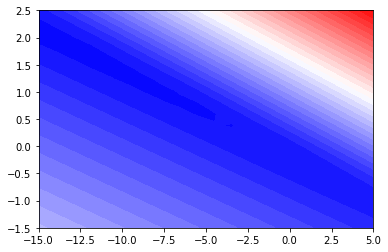

In [11]:
theta0 = np.linspace(-15, 5, 20)
theta1 = np.linspace(-1.5, 2.5, 20)
theta0, theta1 = np.meshgrid(theta0, theta1)

# see stackoverflow.com/questions/9170838/surface-plots-in-matplotlib
zs = np.array([f_loss(np.array([t0, t1])) for t0,t1 in zip(np.ravel(theta0), np.ravel(theta1))])
Z = zs.reshape(theta0.shape)
    
cmap = cm.get_cmap('bwr')   # red value is high, dark blue is low
plt.contourf(theta0, theta1, Z, 30, cmap=cmap);      # filled contour map

### Logistic regression using gradient descent

A simplified version of the logistic regression gradients function that does not expose the training data as parameters.

In [12]:
# create version of log loss function with single vector input
def f_grads(theta):
    return logistic_gradient(theta, X_aug, y)

Perform gradient descent.

In [13]:
gd_coefs = grad_descent(f_grads, 2, alpha=0.01, max_iterations=30000, min_change=0.0001)
print(gd_coefs)
print(f_loss(gd_coefs))

stopped on max iterations
[-6.30798433  0.8114522 ]
0.42063555832082156


### Logistic regression using Scikit Learn

In [14]:
lr_clf = LogisticRegression()
lr_clf.fit(X, y)
lr_clf.score(X, y)
sk_coefs = np.array([lr_clf.intercept_[0], lr_clf.coef_[0,0]])
print(sk_coefs)
print(f_loss(sk_coefs))

[-7.16254904  0.94370368]
0.40731489964464973


In [15]:
# compute accuracy using coefficients
def accuracy(theta) :
    y_pred = logistic(X_aug.dot(theta))
    y_pred = np.where(y_pred > 0.5, 1, 0)
    return accuracy_score(y, y_pred)

print(accuracy(gd_coefs))
print(accuracy(sk_coefs))

0.7979591836734694
0.8081632653061225


Plot logistic curve over the data

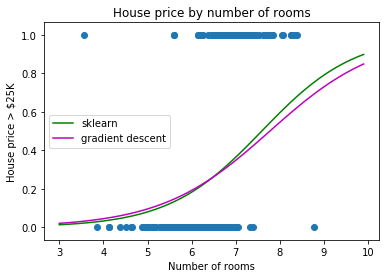

In [18]:
domain = np.arange(3,10,0.1)
X0 = np.ones((len(domain),1))
X_test = np.hstack((X0, domain.reshape(-1, 1)))

plt.scatter(X, y)
plt.xlabel('Number of rooms')
plt.ylabel('House price > $25K')
plt.title('House price by number of rooms');

plt.plot(domain, logistic(X_test.dot(sk_coefs)),'g', label='sklearn')
plt.plot(domain, logistic(X_test.dot(gd_coefs)),'m', label='gradient descent')

plt.legend(loc='center left');